In [1]:
import h5py
import timm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from ZOO_lightning import LitNeuralNet

DTYPE = torch.float32
DEVICE = 'mps:0'

/Users/davidchemaly/miniforge3/envs/Torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: davidchemaly. Use `wandb login --relogin` to force relogin


In [ ]:
SEED = 42
DATA_PATH = '/Volumes/ES-HDD-Documents/Documents/matlas_dwarfs/NGC4249_224_patches.h5'
WEIGHTS_PATH = './effnetb0_color_224px.ckpt'

CHECKPOINT_PATH = './ZOO-e100-lr0.0003-bs2-seed42/ZOO-epoch=11-train_loss=0.0171-valid_loss=0.0088.ckpt'

In [47]:
# Load the Data
arg_valid       = np.loadtxt(f'arg_valid_seed{SEED}.txt').astype(int)
arg_interesting = np.loadtxt('arg_interesting.txt').astype(int)

with h5py.File(DATA_PATH, 'r') as f:
    patches_rgi   = np.arcsinh(f['data'][arg_valid[arg_interesting]]) 
    patches_dwarf = f['dwarf'][arg_valid[arg_interesting]] 
patches_binary = (np.sum( patches_dwarf, axis=(1,2,3) ) != 0).astype(int)

(9801, 1, 224, 224)


In [3]:
# Load the Model
ZOO_model = timm.create_model('efficientnet_b0', pretrained=False)

# Load the state dict from the .ckpt file
original_state_dict = torch.load(WEIGHTS_PATH, map_location=torch.device('cpu'))['state_dict']

adjusted_state_dict = {}
for key, value in original_state_dict.items():
    if key.startswith('encoder.'):
        adjusted_state_dict[key.replace('encoder.', '')] = value
    if key.startswith('head.1.0.'):
        adjusted_state_dict[key.replace('head.1.0.', 'classifier.')] = value
adjusted_state_dict.pop('classifier.weight', None)
adjusted_state_dict.pop('classifier.bias', None)

ZOO_model.load_state_dict(adjusted_state_dict, strict=False)

model = LitNeuralNet.load_from_checkpoint(checkpoint_path=CHECKPOINT_PATH, ZOO_model=ZOO_model)
model.eval();

Lightning automatically upgraded your loaded checkpoint from v1.7.7 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ZOO-e100-lr0.0003-bs2-seed42/ZOO-epoch=11-train_loss=0.0171-valid_loss=0.0088.ckpt`


In [4]:
y_pred = model.forward(torch.tensor(patches_rgi).to(DTYPE))
probs  = torch.sigmoid(y_pred.squeeze())  
preds  = np.array((probs > 0.5).long().long().detach().cpu())

In [5]:
arg_TP = np.where( patches_binary * preds == 1)[0]
arg_FP = np.where( (1-patches_binary) * preds == 1)[0]
arg_FN = np.where( patches_binary * (1-preds) == 1)[0]

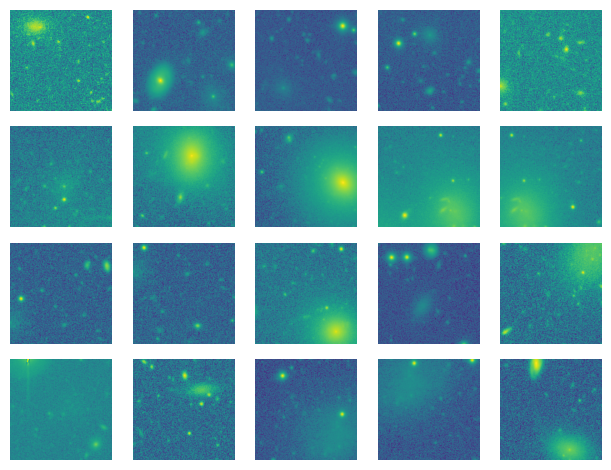

In [55]:
# plt.figure(figsize=(10, 5))
for i in range(len(arg_TP)):
    plt.subplot(4, 5, i+1)
    plt.imshow(patches_rgi[arg_TP[i], 0].T)
    plt.axis('off')
    plt.tight_layout()

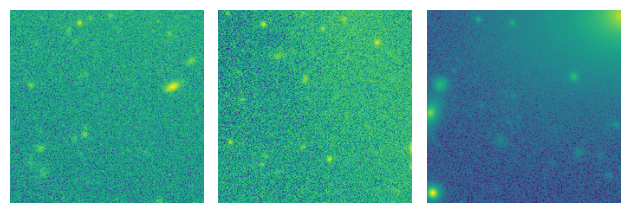

In [57]:
for i in range(len(arg_FP)):
    plt.subplot(1, len(arg_FP), i+1)
    plt.imshow(patches_rgi[arg_FP[i], 0].T)
    plt.axis('off')
    plt.tight_layout()